In [1]:
import pandas as pd
from matplotlib import pyplot as plt
df=pd.read_csv("data/xgboost_perfomance.csv")

In [3]:
df.shape

(244, 21)

In [4]:
df.columns

Index(['experiment_name', 'mean_fit_time', 'mean_score_time',
       'mean_test_score', 'param_alpha', 'param_colsample_bytree',
       'param_gamma', 'param_lambda', 'param_max_depth',
       'param_min_child_weight', 'param_subsample', 'params',
       'rank_test_score', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'std_fit_time', 'std_score_time', 'std_test_score'],
      dtype='object')

In [6]:
df.loc[:,'experiment_name'].unique()

array(['grid search', 'random search', 'random search for 1 group',
       'random search for 2 group', 'random search for 3 group',
       'default params'], dtype=object)

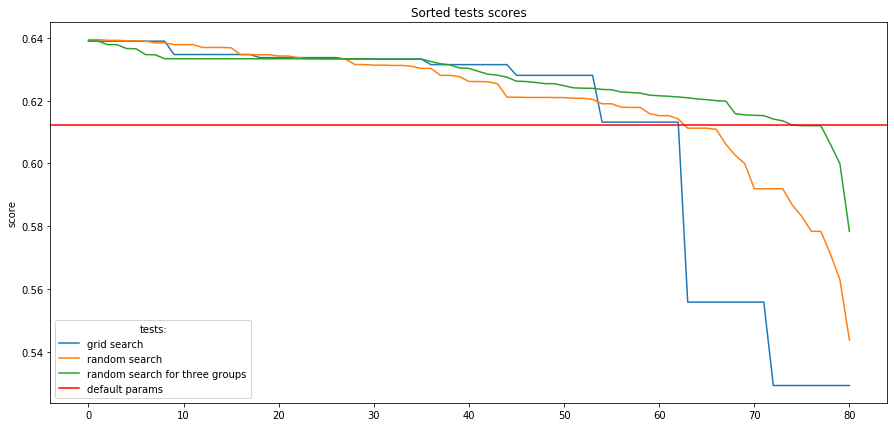

In [39]:
#comparison

name1='grid search'
data1=df.loc[df['experiment_name']==name1, 'mean_test_score'].sort_values(ascending=False)

name2='random search'
data2=df.loc[df['experiment_name']==name2, 'mean_test_score'].sort_values(ascending=False)

name3_1='random search for 1 group'
data3_1=df.loc[df['experiment_name']==name3_1, 'mean_test_score']
name3_2='random search for 2 group'
data3_2=df.loc[df['experiment_name']==name3_2, 'mean_test_score']
name3_3='random search for 3 group'
data3_3=df.loc[df['experiment_name']==name3_3, 'mean_test_score']
name3='random search for three groups'
data3=pd.concat([data3_1,data3_2,data3_3]).sort_values(ascending=False)

name4='default params'
data4=df.loc[df['experiment_name']==name4, 'mean_test_score']

plt.figure(figsize=(15,7))
x=list(range(0, len(data1)))
plt.plot(x, data1, label=name1)
plt.plot(x, data2, label=name2)
plt.plot(x, data3, label=name3)
plt.axhline(data4.values, label=name4, color='r')
plt.legend(title='tests:')
plt.title("Sorted tests scores")
plt.ylabel("score r2")
plt.show()

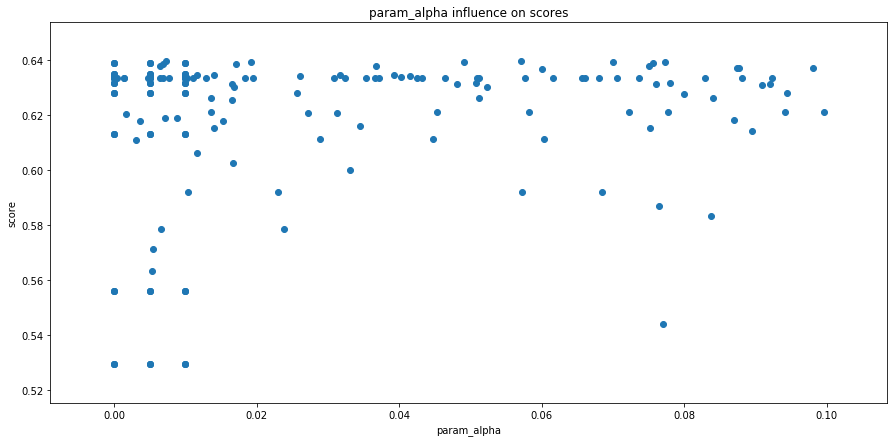

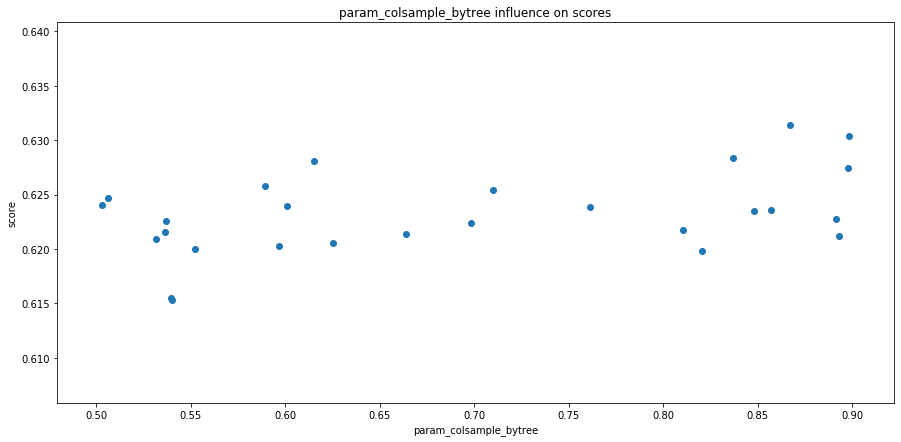

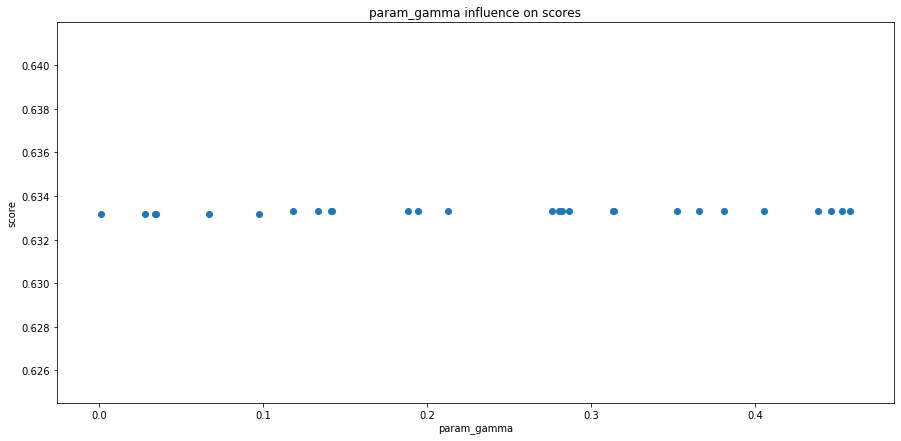

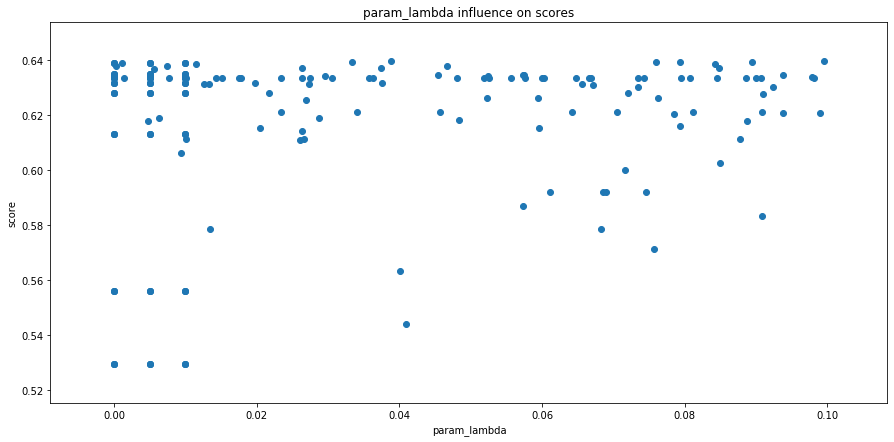

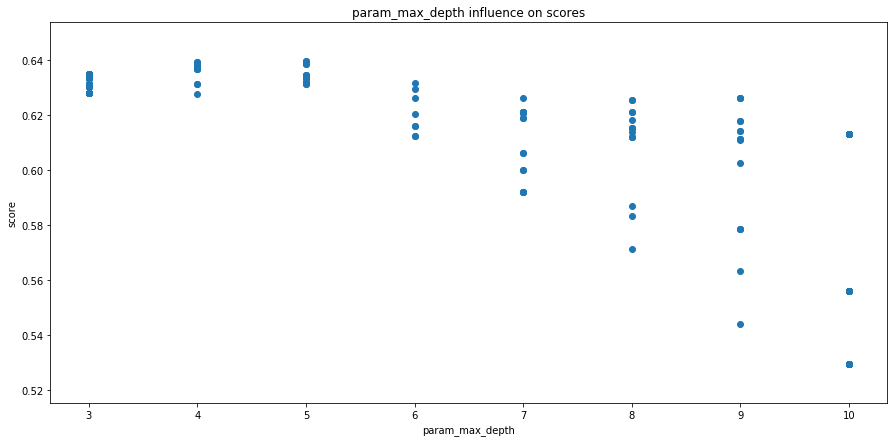

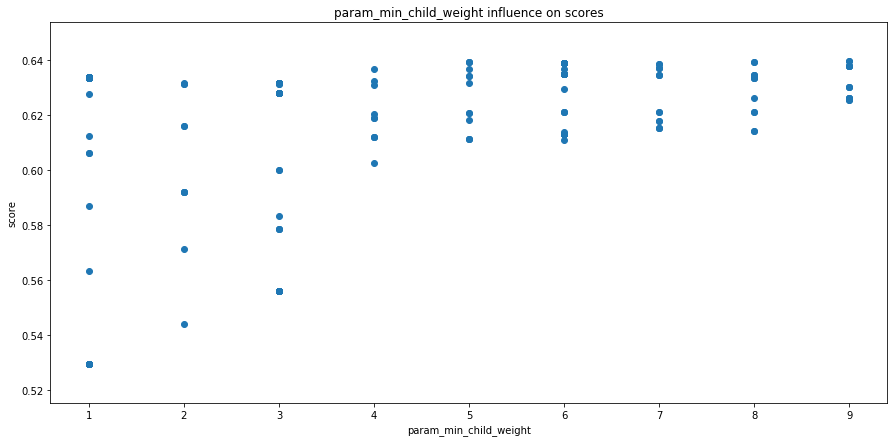

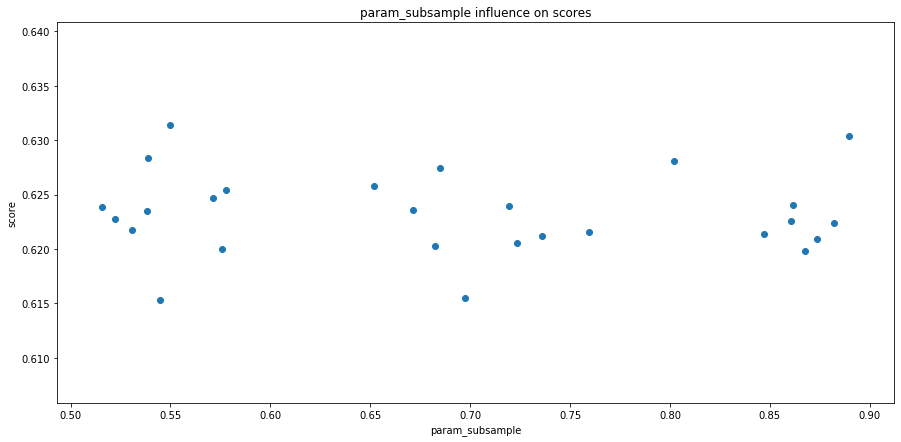

In [46]:
#params influence


params_list=['param_alpha', 'param_colsample_bytree',
       'param_gamma', 'param_lambda', 'param_max_depth',
       'param_min_child_weight', 'param_subsample']

for param in params_list:
    df.loc[:,param].unique().sort

    plt.figure(figsize=(15,7))
    x=df.loc[:,param]
    y=df.loc[:,'mean_test_score']
    plt.scatter(x, y)

    plt.title(param+" influence on scores")
    plt.xlabel(param)
    plt.ylabel("score r2")
    plt.show()